Reproduce the famous droplet autoconversion "ridgeline" plot from [Berry and Reinhardt, 1974](https://journals.ametsoc.org/view/journals/atsc/31/7/1520-0469_1974_031_1814_aaocdg_2_0_co_2.xml) (BR74). It's often re-produced in manners like this:

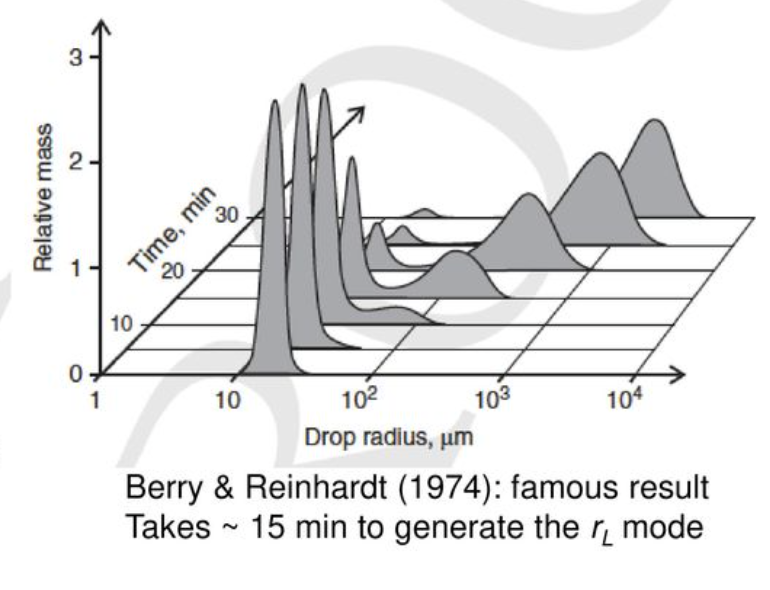

We previously simulated the underlying process in Julia and saved outputs; here we just stitch together the output plot.

In [211]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])
import seaborn as sns

import numpy as np
from pathlib import Path

In [2]:
pth = Path("output")
fns = list(sorted(pth.glob("output_*.npy")))

data = []
for fn in fns:
    print(fn)
    arr = np.load(fn)*1e3
    data.append(arr)
data = np.asarray(data)

rs = np.load(Path("output/r_grid.npy"))*1e6

output/output_001.npy
output/output_002.npy
output/output_003.npy
output/output_004.npy
output/output_005.npy
output/output_006.npy
output/output_007.npy
output/output_008.npy
output/output_009.npy
output/output_010.npy
output/output_011.npy
output/output_012.npy


In [47]:
import xarray as xr

da = xr.DataArray(
    np.asarray(data), 
    coords=[
        ("time", 5*np.arange(len(data))),
        ("r", rs), 
    ], 
    dims=['time', 'r', ])
da

<xarray.DataArray (time: 12, r: 360)>
array([[0.00000000e+00, 3.77944105e-12, 4.76179645e-12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.99947577e-12, 3.77910187e-12, 4.76136885e-12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.99904341e-12, 3.77855694e-12, 4.76068200e-12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.54141151e-14, 1.94192136e-14, 2.44646606e-14, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.85145448e-15, 6.11199013e-15, 7.69994135e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.64284940e-15, 2.06969561e-15, 2.60740768e-15, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * time     (time) int64 0 5 10 15 20 25 30 35 40 45 50 55
  * r        (r) float64 0.1 0.1039 0.108 ... 9.342e+04 9.709e+04 1.009e+05

Sketch a basic plot.

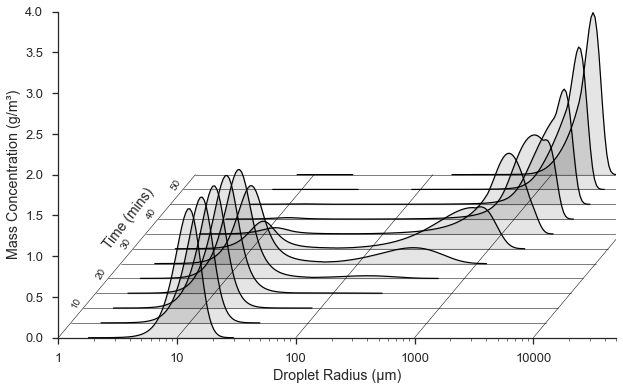

In [240]:
import matplotlib.ticker as mticker

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

skew_θ = (60)*np.pi/180 # radians

rlims = (1, 10_000)
r_lines = [1, 10, 100, 1_000, 10_000, ]

tlims = (0, 55)
t_lines = da.time.values
nt = len(t_lines)

zlims = (0, 2)

# Compute the ratio of t-z so we can figure out the vertical
# spacing of the time grid
t_max, z_max = tlims[1], zlims[1]
t_to_z = z_max / t_max


# Plot the background radius-time space grid

# Constant r - varying time
for r in r_lines:
    Δlogr = np.log10(r)
    Δz = zlims[1]
    lr = np.power(10, Δlogr)
    rr = np.power(10, Δlogr + Δz/np.tan(skew_θ))
    # print(r, lr, rr)
    ax.plot([lr, rr], [0, Δz], color='k', lw=0.5)
    
# Constant time - varying r
for t in t_lines:
    Δz = t * t_to_z
    Δlogr = Δz / np.tan(skew_θ)
    lr = np.power(10, np.log10(rlims[0]) + Δlogr)
    rr = np.power(10, np.log10(rlims[1]) + Δlogr)
    # print(t, Δz, Δr0, lr, rr)
    ax.plot([lr, rr], [Δz, Δz], color='k', lw=0.5)
    
# Time labels
for t in t_lines[2::2]:
    Δz = t * t_to_z
    Δlogr = Δz / np.tan(skew_θ)
    lr = np.power(10, np.log10(rlims[0]) + Δlogr)
    ax.text(lr, Δz, f'{t:d}', ha='right', rotation=skew_θ*180./np.pi)
    if t == 30:
        ax.text(lr-2, Δz, 'Time (mins)',
                # lr-5, Δz, 'Time (mins)', 
                ha='left', rotation=skew_θ*180./np.pi - 7.5,
                fontsize=14
               ) 
    
# Actual plot lines
for t in t_lines:
    Δz = t * t_to_z
    Δlogr = Δz / np.tan(skew_θ)
    z0 = da.sel(time=t)
    _rs = np.power(10., np.log10(da.r) + Δlogr)
    z0 = z0.where((z0 > 1e-4) & (_rs > Δlogr))
    _zs = z0 + Δz
    # print(t, Δz, Δlogr, _rs.values[0], z0.values[0])
    ax.plot(_rs, _zs, color='k', lw=1.2)
    ax.fill_between(_rs, _zs, Δz, where=z0>1e-4, 
                    color='k', alpha=0.1, lw=1.2)
    
ax.semilogx()
ax.set_xlim(1, 50_000)
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter("%d"))
ax.set_xlabel("Droplet Radius (μm)")

ax.set_ylim(0, 4)
ax.set_ylabel("Mass Concentration (g/m³)")

sns.despine()

plt.savefig("")